In [ ]:
#load dependecies
from google.colab import drive
drive.mount('/content/drive/')

import tensorflow as tf
from tensorflow.keras import regularizers
import keras as k

import matplotlib.pyplot as plt
import torchsummary as summary
import numpy as np
np.random.seed(53702)
import pandas as pd
import os

!pip install shap --quiet
import shap
%matplotlib inline

!pip install scikit-survival --quiet

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input,LSTM
from keras.backend import dropout 

!pip install lifelines --quiet
import lifelines
from lifelines import CoxPHFitter

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib as mpl

from pylab import rcParams
import seaborn as sns 
import pdb

Mounted at /content/drive/
     |████████████████████████████████| 569 kB 6.9 MB/s 
     |████████████████████████████████| 3.1 MB 6.5 MB/s 
     |████████████████████████████████| 349 kB 9.1 MB/s 
     |████████████████████████████████| 76 kB 4.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.0 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.3.0 which is incompatible.
spacy 3.4.1 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.3.0 which is incompatible.


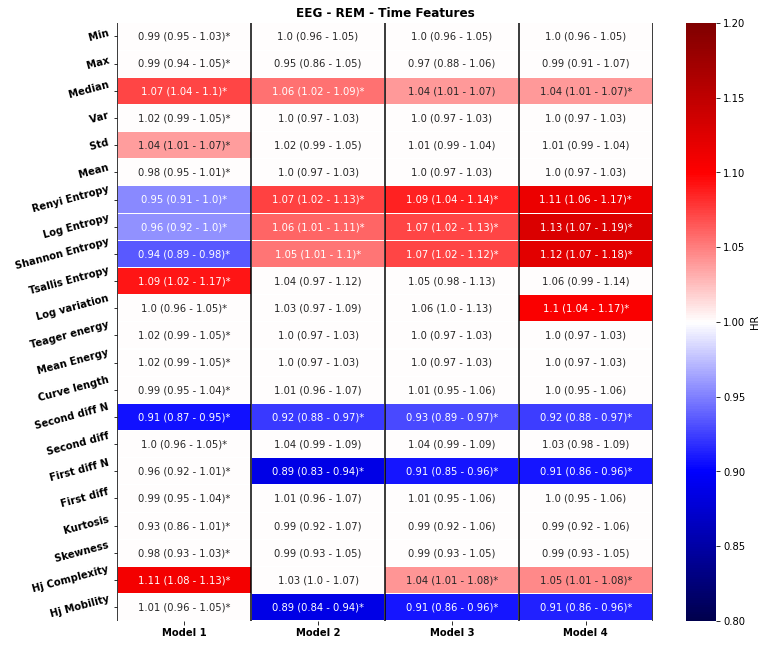

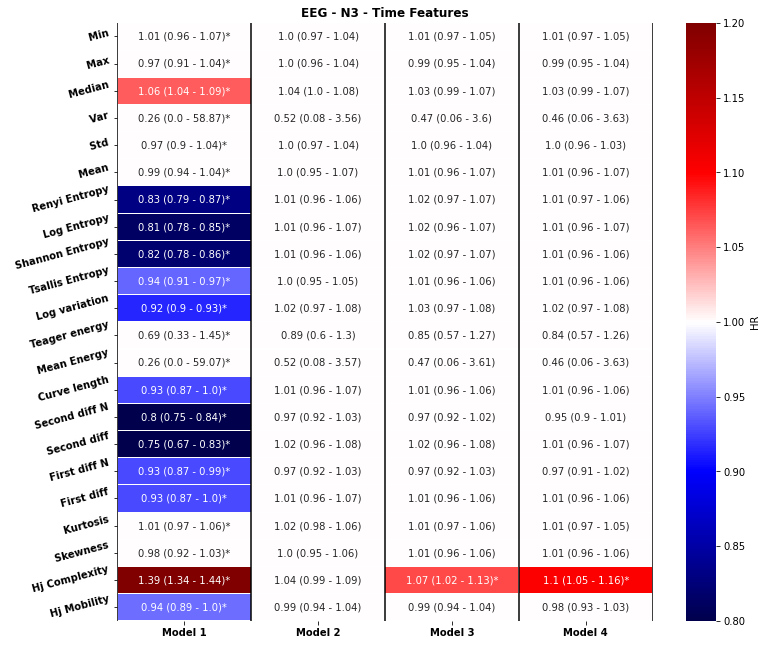

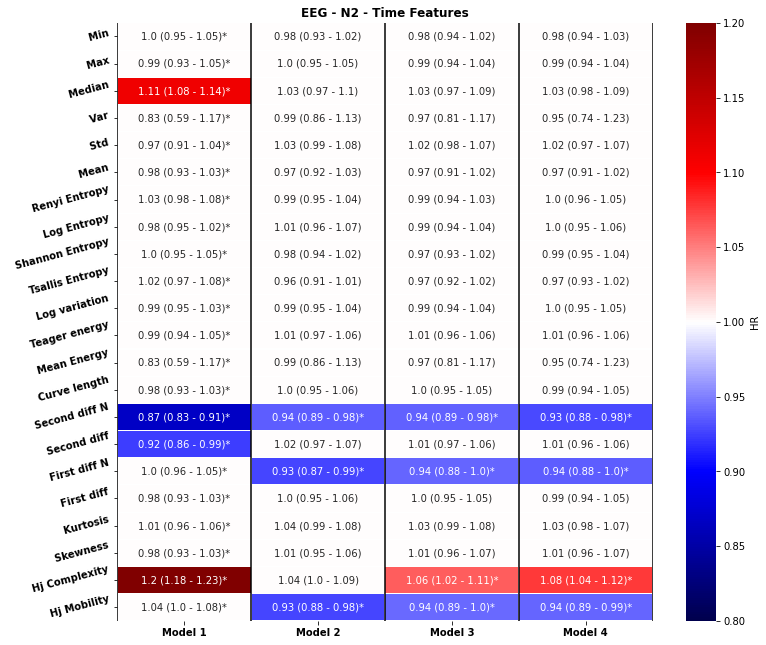

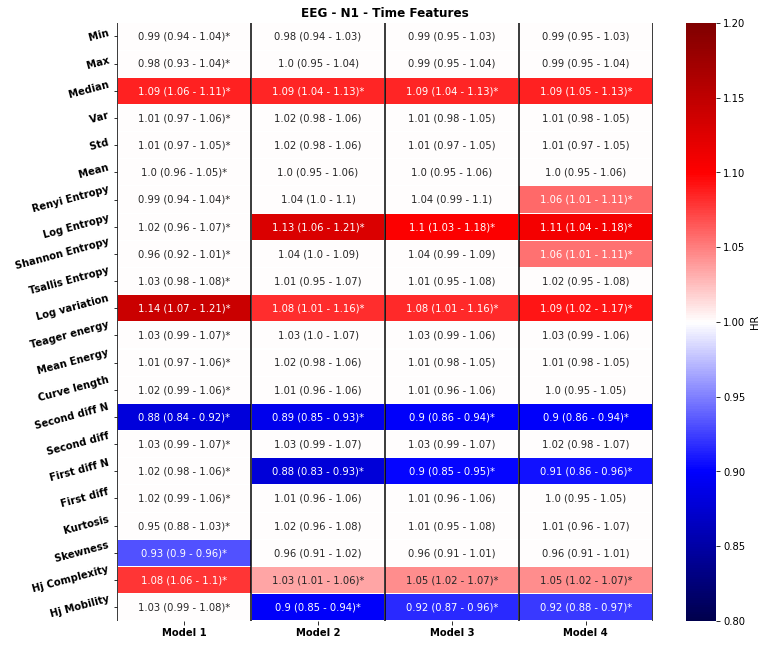

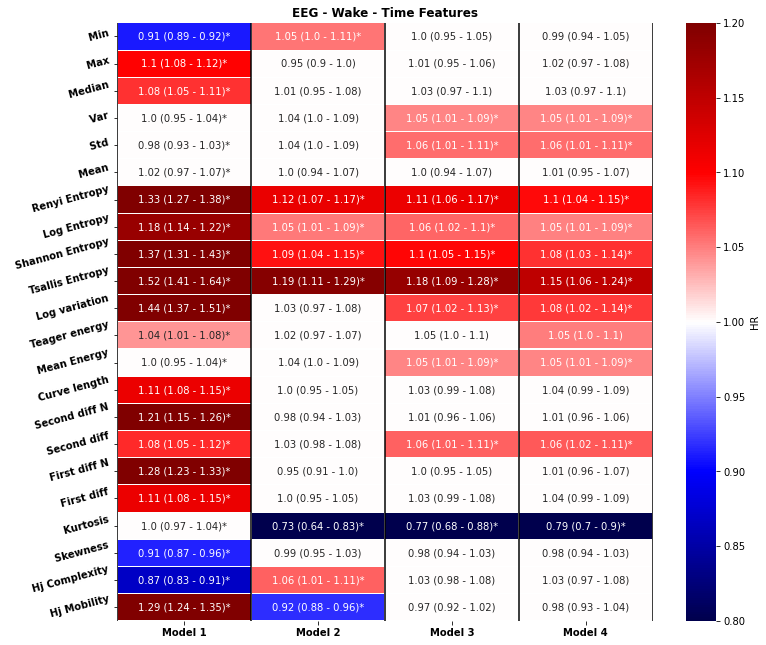

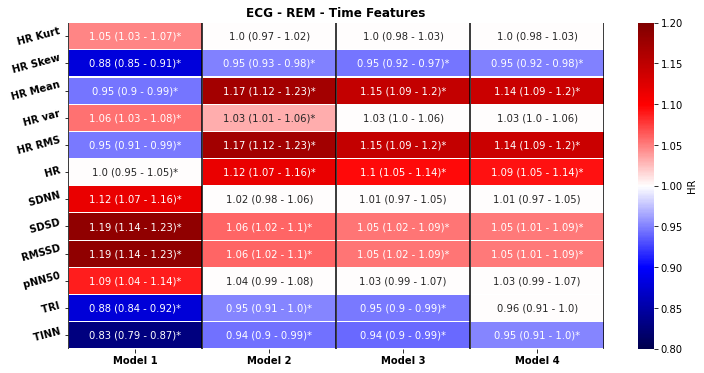

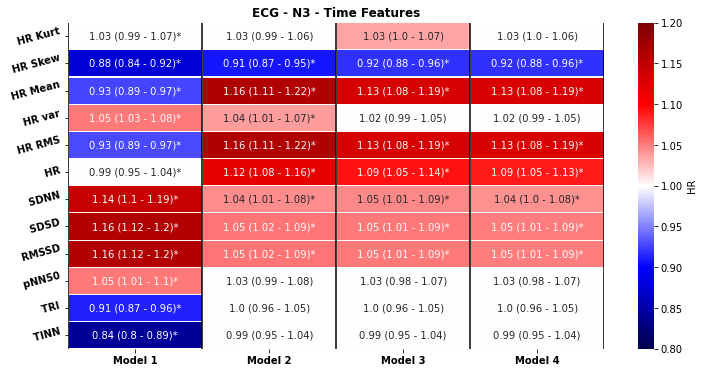

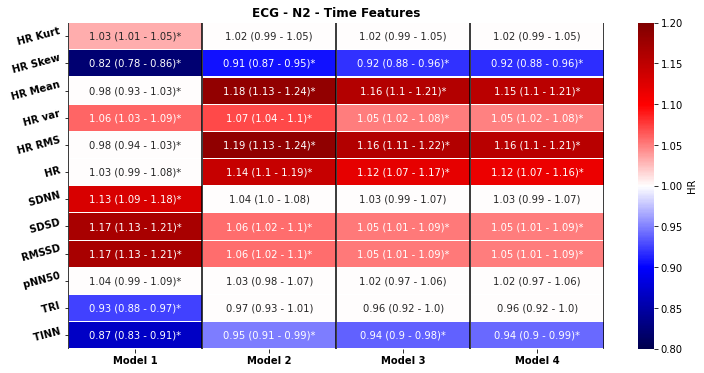

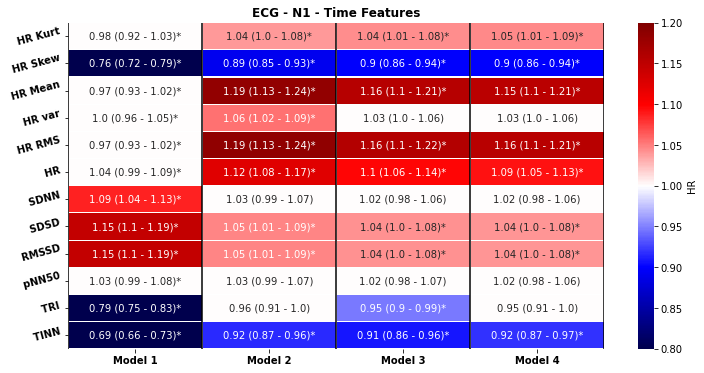

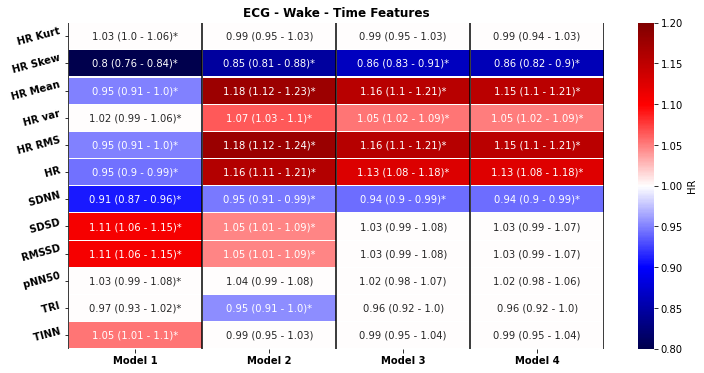

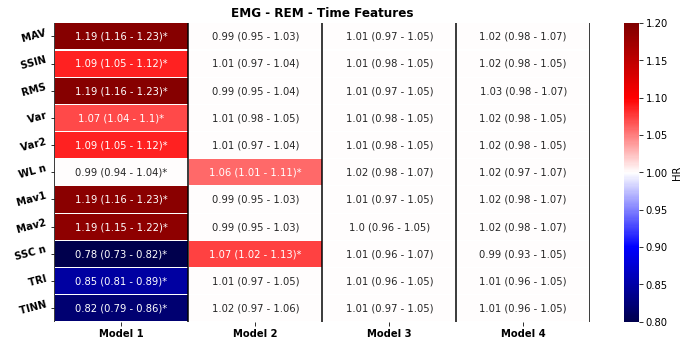

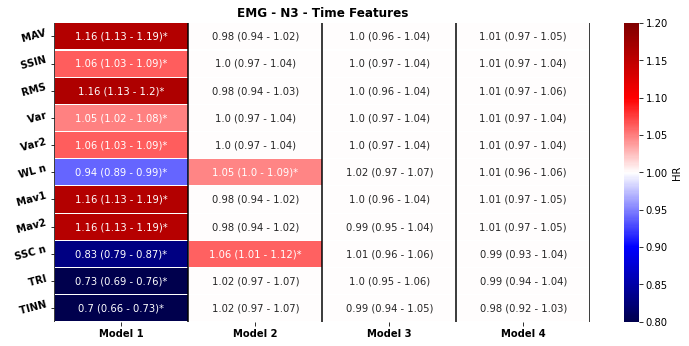

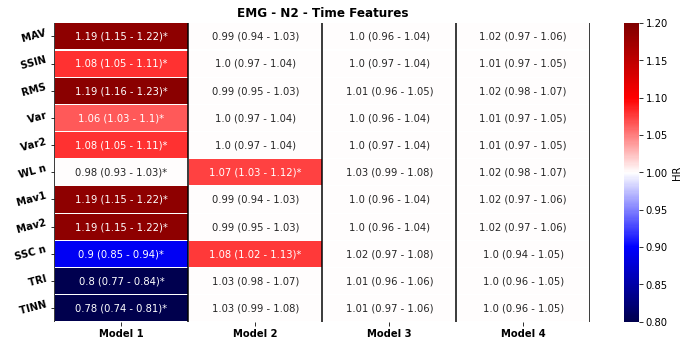

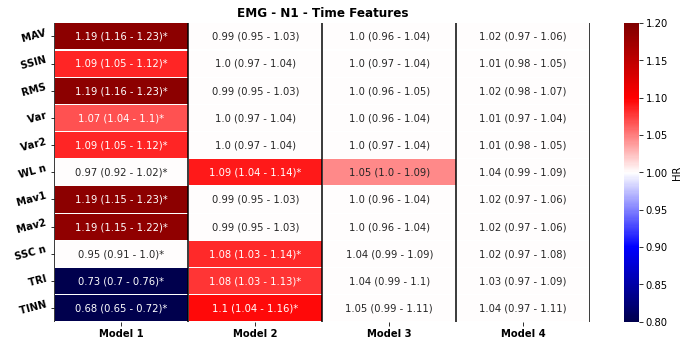

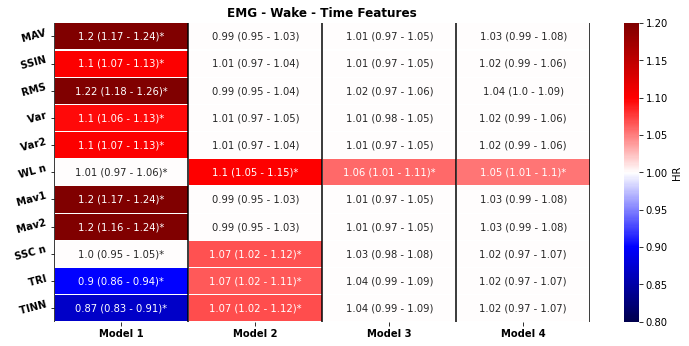

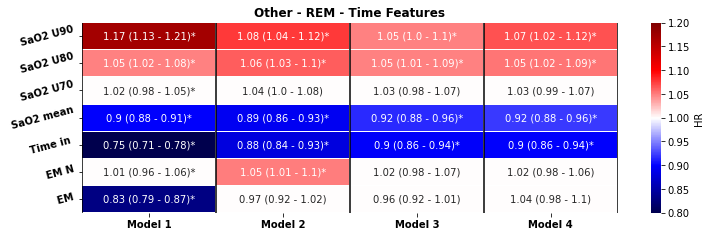

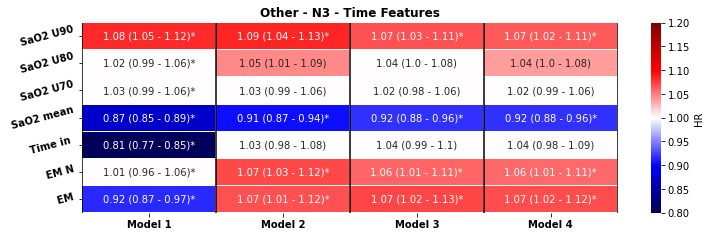

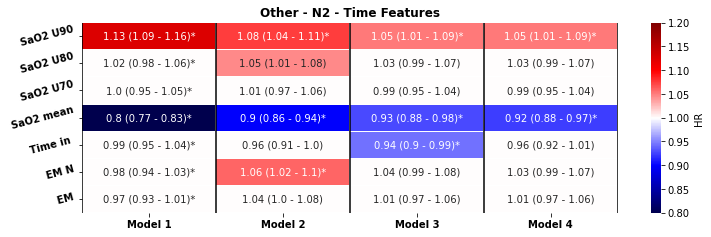

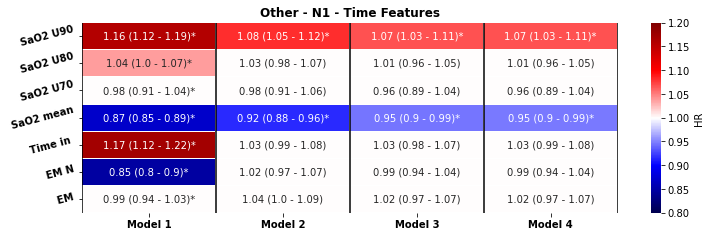

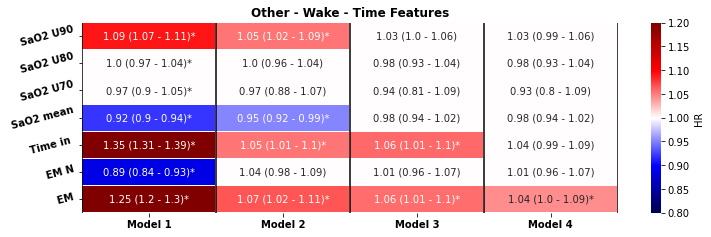

In [ ]:
## A detailed table of hazard ratios and confidence intervals

Stages=['REM','N3','N2','N1','Wake']

Modalities=['EEG','ECG','EMG','Other']

OutNames=['Single Effect','Multi Effect']

#For loop iterating over modality, stages, and single effect/multi effect
for Modality in Modalities:

  for Stage in Stages:

    Out_Name=Modality + '_' + Stage

    os.chdir('/content/drive/MyDrive/Speciale/DL after 14-06/Visualize_bands/P_data_time_loglik')
    Comb_M1 = pd.read_csv(' P_data_Time'  + '_' + 'Model_1' +  '.csv')
    Comb_M2 = pd.read_csv(' P_data_Time'  + '_' + 'Model_2'  +'.csv')
    Comb_M3 = pd.read_csv(' P_data_Time'  + '_' + 'Model_3'  +'.csv')
    Comb_M4 = pd.read_csv(' P_data_Time'  + '_' + 'Model_4'  +'.csv')

    strings=Comb_M1.Name
    substrings=['Delta','Theta','Alpha','Beta','Gamma','Hjort_activity','A_B_Ratio']
    for substring in substrings:
      remalph = [i for i, elem in enumerate(strings) if substring in elem]
      Comb_M1=Comb_M1.drop(remalph)
      Comb_M2=Comb_M2.drop(remalph)
      Comb_M3=Comb_M3.drop(remalph)
      Comb_M4=Comb_M4.drop(remalph)

    Comb_M1=Comb_M1.reset_index()
    Comb_M2=Comb_M2.reset_index()
    Comb_M3=Comb_M3.reset_index()
    Comb_M4=Comb_M4.reset_index()

    AllModalyties=Comb_M1.Modality
    colnames=Comb_M1.columns

    indexsaver=[]
    for modindx in range(len(AllModalyties)):
      modalitycheck=AllModalyties[modindx]
      if Modality == modalitycheck:
        indexsaver=np.append(indexsaver,[modindx])

    indexsaver=indexsaver.astype(int)
    Comb_M1t = pd.DataFrame(Comb_M1.to_numpy()[indexsaver],columns=colnames)
    Comb_M2t = pd.DataFrame( Comb_M2.to_numpy()[indexsaver],columns=colnames)
    Comb_M3t = pd.DataFrame( Comb_M3.to_numpy()[indexsaver],columns=colnames)
    Comb_M4t = pd.DataFrame( Comb_M4.to_numpy()[indexsaver],columns=colnames)


    AllStages=Comb_M1t.Sleepstage
    #Stage='REM'
    indexsaver=[]
    for Stageidx in range(len(AllStages)):
      stagecheck=AllStages[Stageidx]
      if Stage == stagecheck:
        indexsaver=np.append(indexsaver,[Stageidx])

    indexsaver=indexsaver.astype(int)
    Comb_M1t = pd.DataFrame(Comb_M1t.to_numpy()[indexsaver],columns=colnames)
    Comb_M2t = pd.DataFrame( Comb_M2t.to_numpy()[indexsaver],columns=colnames)
    Comb_M3t = pd.DataFrame( Comb_M3t.to_numpy()[indexsaver],columns=colnames)
    Comb_M4t = pd.DataFrame( Comb_M4t.to_numpy()[indexsaver],columns=colnames)

    os.chdir('/content/drive/MyDrive/Speciale/DL after 14-06/Visualize_bands/')
    Rv=Comb_M1t["P_val"]
    N3v=Comb_M2t["P_val"]
    N2v=Comb_M3t["P_val"]
    N1v=Comb_M4t["P_val"]


    P_val_Nd = np.vstack((Rv, N3v,N2v,N1v)).T
    p_org=P_val_Nd

    Rv=Comb_M1t["HR"].astype(float)
    N3v=Comb_M2t["HR"].astype(float)
    N2v=Comb_M3t["HR"].astype(float)
    N1v=Comb_M4t["HR"].astype(float)

    HR_Nd = np.vstack((Rv, N3v,N2v,N1v)).T

    NewNames=Comb_M1t.Name
    
    for i in range(len(NewNames)):
      NewNames[i]=NewNames[i].replace(Stage,'')

    for i in range(len(NewNames)):
      NewNames[i]=NewNames[i].replace(Modality,'')
    for i in range(len(NewNames)):
      NewNames[i]=NewNames[i].replace('_',' ')

    CombHRandCI=[]
    
    for i in range(len(NewNames)):
      HRstr=str(round(Comb_M1t["HR"][i],2))
      CILstr=str(round(Comb_M1t['LowerCI'][i],2))
      CIHstr=str(round(Comb_M1t['UpperCI'][i],2))
      if Comb_M1t['LogLik'][i]==1:
        sigstring='*'
      else:
        sigstring=''
      CombHRandCI.append(HRstr + ' (' + CILstr + ' - ' + CIHstr +')' + sigstring)

    
    M1_list=CombHRandCI

    CombHRandCI=[]
    for i in range(len(NewNames)):
      HRstr=str(round(Comb_M2t["HR"][i],2))
      CILstr=str(round(Comb_M2t['LowerCI'][i],2))
      CIHstr=str(round(Comb_M2t['UpperCI'][i],2))
      if Comb_M2t['LogLik'][i]==1:
        sigstring='*'
      else:
        sigstring=''
      CombHRandCI.append(HRstr + ' (' + CILstr + ' - ' + CIHstr +')' + sigstring)
    
    M2_list=CombHRandCI

    CombHRandCI=[]
    for i in range(len(NewNames)):
      HRstr=str(round(Comb_M3t["HR"][i],2))
      CILstr=str(round(Comb_M3t['LowerCI'][i],2))
      CIHstr=str(round(Comb_M3t['UpperCI'][i],2))
      if Comb_M3t['LogLik'][i]==1:
        sigstring='*'
      else:
        sigstring=''
      CombHRandCI.append(HRstr + ' (' + CILstr + ' - ' + CIHstr +')' + sigstring)
    
    M3_list=CombHRandCI

    CombHRandCI=[]
    
    for i in range(len(NewNames)):
      HRstr=str(round(Comb_M4t["HR"][i],2))
      CILstr=str(round(Comb_M4t['LowerCI'][i],2))
      CIHstr=str(round(Comb_M4t['UpperCI'][i],2))
      if Comb_M4t['LogLik'][i]==1:
        sigstring='*'
      else:
        sigstring=''
      CombHRandCI.append(HRstr + ' (' + CILstr + ' - ' + CIHstr +')' + sigstring)
    
    M4_list=CombHRandCI

    Str_Intervals=pd.DataFrame([M1_list,M2_list,M3_list,M4_list]).T
    Str_Intervals.columns=['M1','M2','M3','M4']

    Str_Intervals.index = NewNames.values

    df = Str_Intervals

    P_val_Nd=p_org
    Colors=P_val_Nd
    HR_2=HR_Nd
    for i in range(len(P_val_Nd)):
      for j in range(4):
        if P_val_Nd[i][j]>=0.05:
          HR_2[i][j]=1;
    HR_2=pd.DataFrame(HR_2)

    Colors=pd.DataFrame(Colors)

    rcParams['figure.figsize'] = 12, 0.5*(np.shape(df)[0])
    plt.figure()
    ax=sns.heatmap(HR_2, annot=df, cmap="seismic", cbar=True, lw=0.01,fmt = '', vmin=0.8, vmax=1.2)
    

    ax.set_xticklabels(['Model 1','Model 2','Model 3','Model 4'],weight='bold')
    ax.set_yticklabels(NewNames,weight='bold')
    ax.vlines([0, 1, 2, 3, 4, 5], *ax.get_ylim())
    ax.set_title(Modality + ' - ' +  Stage + ' - Time Features' ,weight='bold')
    ax.tick_params(axis='y', rotation=0)
    outname=Modality + ' - ' +  Stage + ' - Time Features'

    ax.collections[0].colorbar.set_label("HR")

    #File Directory and saving
    script_dir = os.getcwd()
    out_extend= 'P_data_loglik_T/Detailed_'+ Modality + '_' +'/' 
    results_dir = os.path.join(script_dir, out_extend )
    sample_file_name = outname

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    plt.yticks(rotation = 15)

    plt.savefig( results_dir + sample_file_name +'InfoPlot' + '.pdf', bbox_inches="tight",dpi=500)


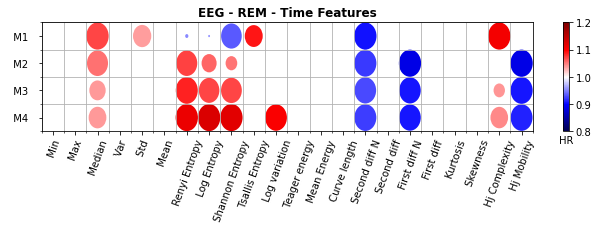

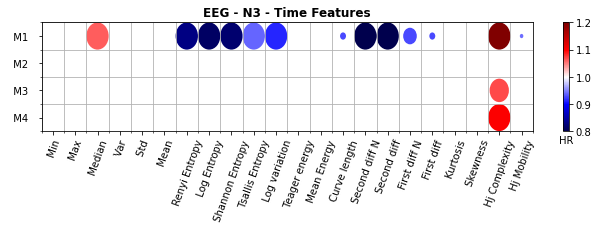

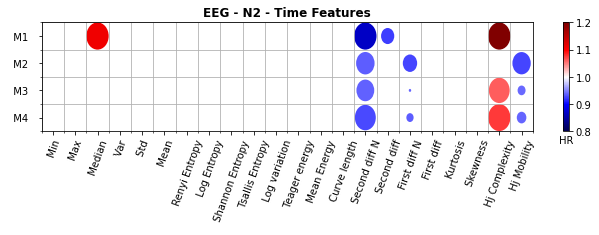

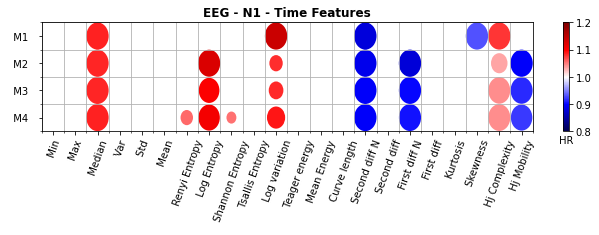

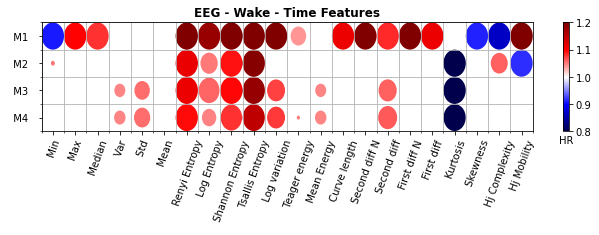

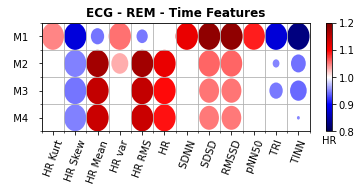

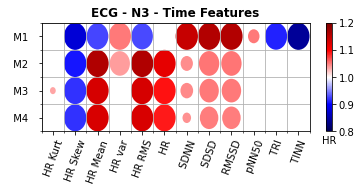

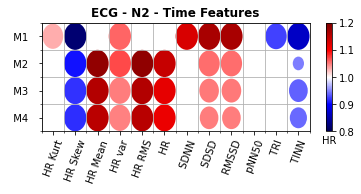

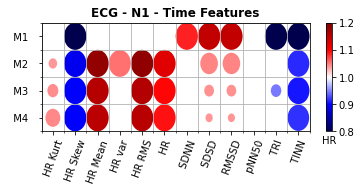

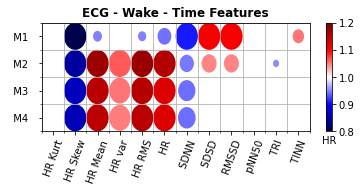

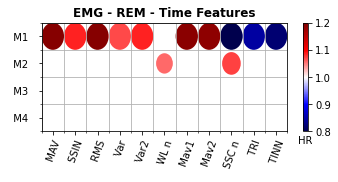

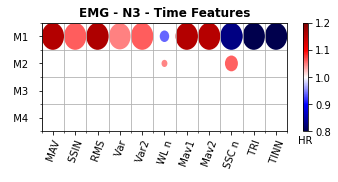

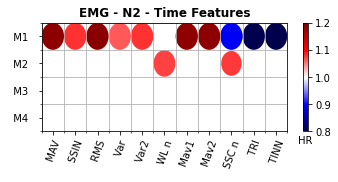

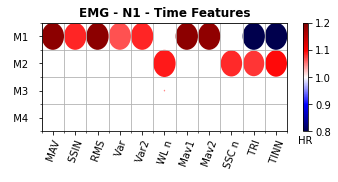

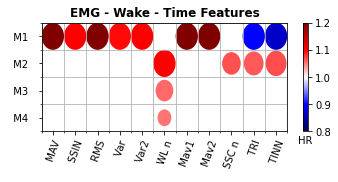

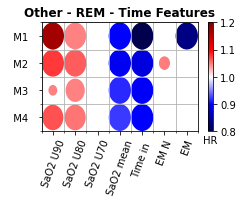

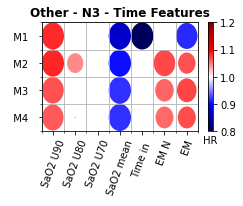

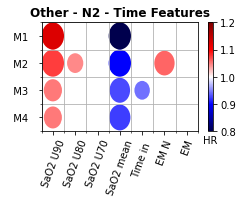

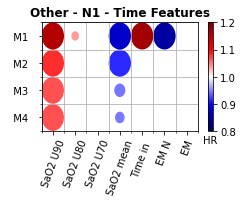

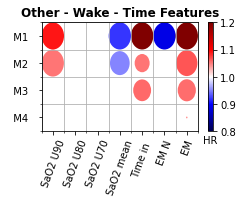

In [ ]:
## A 'dot plot' of hazard ratios and confidence intervals

Stages=['REM','N3','N2','N1','Wake']

Modalities=['EEG','ECG','EMG','Other']

OutNames=['Single Effect','Multi Effect']

#For loop iterating over modality, stages, and single effect/multi effect
for Modality in Modalities:

  for Stage in Stages:

      Out_Name=Modality + '_' + Stage

      os.chdir('/content/drive/MyDrive/Speciale/DL after 14-06/Visualize_bands/P_data_time')
      Comb_M1 = pd.read_csv(' P_data_Time'  + '_' + 'Model_1' +  '.csv')
      Comb_M2 = pd.read_csv(' P_data_Time'  + '_' + 'Model_2'  +'.csv')
      Comb_M3 = pd.read_csv(' P_data_Time'  + '_' + 'Model_3'  +'.csv')
      Comb_M4 = pd.read_csv(' P_data_Time'  + '_' + 'Model_4'  +'.csv')

      strings=Comb_M1.Name
      substrings=['Delta','Theta','Alpha','Beta','Gamma','Hjort_activity','A_B_Ratio']
      for substring in substrings:
        remalph = [i for i, elem in enumerate(strings) if substring in elem]
        Comb_M1=Comb_M1.drop(remalph)
        Comb_M2=Comb_M2.drop(remalph)
        Comb_M3=Comb_M3.drop(remalph)
        Comb_M4=Comb_M4.drop(remalph)

      Comb_M1=Comb_M1.reset_index()
      Comb_M2=Comb_M2.reset_index()
      Comb_M3=Comb_M3.reset_index()
      Comb_M4=Comb_M4.reset_index()

      AllModalyties=Comb_M1.Modality
      colnames=Comb_M1.columns

      indexsaver=[]
      for modindx in range(len(AllModalyties)):
        modalitycheck=AllModalyties[modindx]
        if Modality == modalitycheck:
          indexsaver=np.append(indexsaver,[modindx])

      indexsaver=indexsaver.astype(int)
      Comb_M1t = pd.DataFrame(Comb_M1.to_numpy()[indexsaver],columns=colnames)
      Comb_M2t = pd.DataFrame( Comb_M2.to_numpy()[indexsaver],columns=colnames)
      Comb_M3t = pd.DataFrame( Comb_M3.to_numpy()[indexsaver],columns=colnames)
      Comb_M4t = pd.DataFrame( Comb_M4.to_numpy()[indexsaver],columns=colnames)


      AllStages=Comb_M1t.Sleepstage
      indexsaver=[]
      for Stageidx in range(len(AllStages)):
        stagecheck=AllStages[Stageidx]
        if Stage == stagecheck:
          indexsaver=np.append(indexsaver,[Stageidx])

      indexsaver=indexsaver.astype(int)
      Comb_M1t = pd.DataFrame(Comb_M1t.to_numpy()[indexsaver],columns=colnames)
      Comb_M2t = pd.DataFrame( Comb_M2t.to_numpy()[indexsaver],columns=colnames)
      Comb_M3t = pd.DataFrame( Comb_M3t.to_numpy()[indexsaver],columns=colnames)
      Comb_M4t = pd.DataFrame( Comb_M4t.to_numpy()[indexsaver],columns=colnames)

      os.chdir('/content/drive/MyDrive/Speciale/DL after 14-06/Visualize_bands/')
      Rv=Comb_M1t["P_val"]
      N3v=Comb_M2t["P_val"]
      N2v=Comb_M3t["P_val"]
      N1v=Comb_M4t["P_val"]


      P_val_Nd = np.vstack((Rv, N3v,N2v,N1v)).T
      p_org=P_val_Nd

      Rv=Comb_M1t["HR"].astype(float)
      N3v=Comb_M2t["HR"].astype(float)
      N2v=Comb_M3t["HR"].astype(float)
      N1v=Comb_M4t["HR"].astype(float)

      HR_Nd = np.vstack((Rv, N3v,N2v,N1v)).T

      NewNames=Comb_M1t.Name

      for i in range(len(NewNames)):
        NewNames[i]=NewNames[i].replace(Stage,'')

      for i in range(len(NewNames)):
        NewNames[i]=NewNames[i].replace(Modality,'')
      for i in range(len(NewNames)):
        NewNames[i]=NewNames[i].replace('_',' ')

      CombHRandCI=[]
      for i in range(len(NewNames)):
        HRstr=str(round(Comb_M1t["HR"][i],2))
        CILstr=str(round(Comb_M1t['LowerCI'][i],2))
        CIHstr=str(round(Comb_M1t['UpperCI'][i],2))
        CombHRandCI.append(HRstr + ' (' + CILstr + ' - ' + CIHstr +')')
      
      M1_list=CombHRandCI

      CombHRandCI=[]
      for i in range(len(NewNames)):
        HRstr=str(round(Comb_M2t["HR"][i],2))
        CILstr=str(round(Comb_M2t['LowerCI'][i],2))
        CIHstr=str(round(Comb_M2t['UpperCI'][i],2))
        CombHRandCI.append(HRstr + ' (' + CILstr + ' - ' + CIHstr +')')
      
      M2_list=CombHRandCI

      CombHRandCI=[]
      for i in range(len(NewNames)):
        HRstr=str(round(Comb_M3t["HR"][i],2))
        CILstr=str(round(Comb_M3t['LowerCI'][i],2))
        CIHstr=str(round(Comb_M3t['UpperCI'][i],2))
        CombHRandCI.append(HRstr + ' (' + CILstr + ' - ' + CIHstr +')')
      
      M3_list=CombHRandCI

      CombHRandCI=[]
      for i in range(len(NewNames)):
        HRstr=str(round(Comb_M4t["HR"][i],2))
        CILstr=str(round(Comb_M4t['LowerCI'][i],2))
        CIHstr=str(round(Comb_M4t['UpperCI'][i],2))
        CombHRandCI.append(HRstr + ' (' + CILstr + ' - ' + CIHstr +')')
      
      M4_list=CombHRandCI

      Str_Intervals=pd.DataFrame([M1_list,M2_list,M3_list,M4_list]).T
      Str_Intervals.columns=['M1','M2','M3','M4']

      Str_Intervals.index = NewNames.values
      p_org = P_val_Nd.copy()
      P_val_Nd=p_org

      for i in range(len(P_val_Nd)):
        for j in range(4):
          if P_val_Nd[i][j]>=0.05:
            P_val_Nd[i][j]=0.051;


      N = 4 

      
      M = len(NewNames)

      rcParams['figure.figsize'] = 0.5*M, 2

      ylabels = np.flipud(['  M1  ',' M2  ','  M3  ','  M4  '])
      xlabels = (NewNames)

      P_val_Nd=p_org

      x, y = np.meshgrid(np.arange(M), np.arange(N))
      s = np.flipud(abs(P_val_Nd.T-0.051))
      c = np.flipud(HR_Nd.T)

      fig, ax = plt.subplots()

      R = s/s.max()/2

      circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
      col = PatchCollection(circles, array=c.flatten(), cmap='seismic')
      ax.add_collection(col)

      ax.set(xticks=np.arange(M), yticks=np.arange(N),
            xticklabels=xlabels, yticklabels=ylabels)
      ax.set_xticks(np.arange(M+1)-0.5, minor=True)
      ax.set_yticks(np.arange(N+1)-0.5, minor=True)
      ax.grid(which='minor')


      colorBar=fig.colorbar(col)
      col.set_clim(vmin=0.8, vmax=1.2)
      colorBar.ax.set_xlabel('HR')


      outname=Modality + ' - ' +  Stage + ' - Time Features'

      ax.set_title(outname,weight='bold')

      outname=outname

      #File Directory and saving
      script_dir = os.getcwd()
      out_extend='Time_Dots/' + Modality + '_' +'/' 
      results_dir = os.path.join(script_dir, out_extend )
      sample_file_name = outname

      if not os.path.isdir(results_dir):
          os.makedirs(results_dir)
      plt.xticks(rotation = 70)

      fig.savefig( results_dir + sample_file_name + '.pdf', bbox_inches="tight",dpi=1500)
